# recurrent neural network (RNN) + Cys

In [1]:
import json
import os
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

2.0.0+cu117
1.26.4


In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)

## without Cys

In [23]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep notCys
select = df11[0].apply(lambda x: False if 'C' in x else True)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

df21 = df2.drop_duplicates()
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
0
True     1639058
False     226184
Name: count, dtype: int64
(1639058, 2)
(3185991, 2) (3185991, 2)
(1863999, 2) (1863998, 2)


In [24]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(6689047, 2)


,0,1
2052918,PNPEDIILDG,other
1775681,NSENKESIPSL,other
553751,SHSMPSQFNPANIKKIKAIEYYI,random
3061361,HFPPRCVDM,other
1102057,TAVAPSMTMRCIGIS,other


In [25]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('other', 'PNPEDIILDG')
Counter({'other': 3185991, 'random': 1863998, 'epitope': 1639058})


In [26]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('random', 'CIMPSFKKNCCMNSY')
split data:  4013428 1337809 1337810

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: EFPCSWSVDPQRQQQLVV ['E', 'F', 'P', 'C', 'S', 'W', 'S', 'V', 'D', 'P', 'Q', 'R', 'Q', 'Q', 'Q', 'L', 'V', 'V']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 3872332), ('S', 3302939), ('A', 3275753), ('E', 3061839), ('G', 3056266), ('V', 2887262), ('P', 2727744), ('K', 2690324), ('T', 2574781), ('R', 2570610), ('D', 2458258), ('I', 2271736), ('Q', 2227821), ('N', 2024917), ('F', 1948586), ('Y', 1674837), ('H', 1512078), ('M', 1389902), ('C', 1231553), ('W', 1122194), ('X', 3203), ('U', 81), ('Z', 49), ('B', 45), ('J', 3)])
counts of input: [1911336, 1118397, 983695]

## Step 3 encoding: encoding each unique token into integers...


In [56]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [57]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8222 val_acc: 0.8302, val_recall: 0.7465
Epoch 1 acc: 0.8328 val_acc: 0.8345, val_recall: 0.7617
Epoch 2 acc: 0.8360 val_acc: 0.8354, val_recall: 0.7680
Epoch 3 acc: 0.8373 val_acc: 0.8360, val_recall: 0.7638
Epoch 4 acc: 0.8387 val_acc: 0.8376, val_recall: 0.7674
Epoch 5 acc: 0.8396 val_acc: 0.8381, val_recall: 0.7627
Epoch 6 acc: 0.8402 val_acc: 0.8376, val_recall: 0.7516
Epoch 7 acc: 0.8411 val_acc: 0.8377, val_recall: 0.7588
Epoch 8 acc: 0.8414 val_acc: 0.8382, val_recall: 0.7550
Epoch 9 acc: 0.8419 val_acc: 0.8383, val_recall: 0.7628
Epoch 10 acc: 0.8422 val_acc: 0.8387, val_recall: 0.7681
Epoch 11 acc: 0.8426 val_acc: 0.8386, val_recall: 0.7629
Epoch 12 acc: 0.8428 val_acc: 0.8386, val_recall: 0.7582
Epoch 13 acc: 0.8432 val_acc: 0.8370, val_recall: 0.7664
Epoch 14 acc: 0.8433 val_acc: 0.8389, val_recall: 0.7743
Epoch 15 acc: 0.8434 val_acc: 0.8383, val_recall: 0.7558
Epoch 16 acc: 0.8434 val_acc: 0.8389, val_recall: 0.7657
Epoch 17 acc: 0.8438 val_acc: 0.8389, val

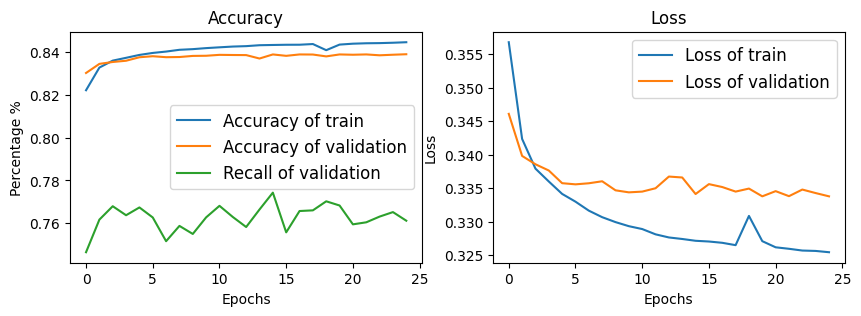

In [59]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [60]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.7610670609753846,
 'accuracy': 0.8388433335077478,
 'loss': 0.3345005326997161}

In [61]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]

,text,predict,labels
0,SLSAYRSSV,3.342233e-01,epitope
1,CCIWHNNPDIGYLAN,1.046121e-24,random
2,MFHRCPTHE,0.000000e+00,random
3,LIEKTNEERKT,8.017354e-02,epitope
4,FDYKLKF,7.481279e-01,random


327737 1010073


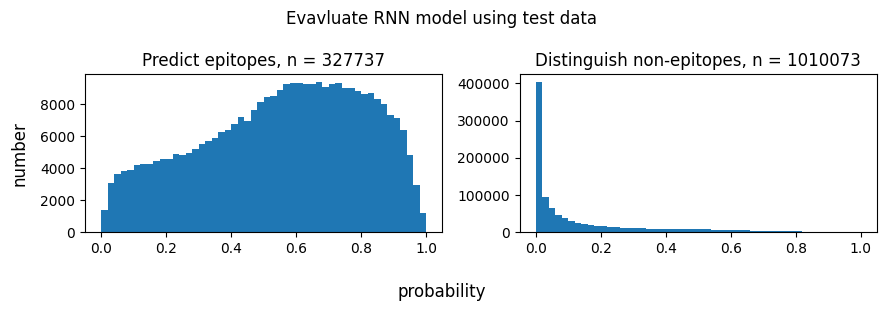

In [62]:
MyEvaluate.plot_prob(pred_test)

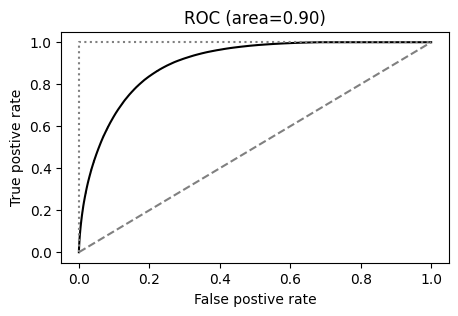

In [63]:
MyEvaluate.plot_roc(pred_test)

In [64]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_notcys.pth')

## has Cys

In [65]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep notCys
select = df11[0].apply(lambda x: True if 'C' in x else False)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

df21 = df2.drop_duplicates()
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
0
False    1639058
True      226184
Name: count, dtype: int64
(226184, 2)
(3185991, 2) (3185991, 2)
(1863999, 2) (1863998, 2)


In [66]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)

(5276173, 2)


,0,1
120254,NTTQEDVQER,other
141018,NFNSMGRH,random
123537,GQQQEERGQ,other
935692,KRGWMQYH,random
1451949,CVNLYKSLSEV,other


In [67]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('other', 'NTTQEDVQER')
Counter({'other': 3185991, 'random': 1863998, 'epitope': 226184})


In [68]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('other', 'ELEQLNAEL')
split data:  3165703 1055234 1055236

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: FNTGTITISL ['F', 'N', 'T', 'G', 'T', 'I', 'T', 'I', 'S', 'L']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 2815728), ('S', 2494239), ('A', 2368424), ('G', 2357438), ('E', 2285579), ('V', 2127010), ('P', 2085824), ('K', 1994131), ('R', 1975217), ('T', 1948996), ('D', 1924267), ('Q', 1732372), ('I', 1708134), ('N', 1597701), ('F', 1517095), ('C', 1399022), ('Y', 1311612), ('H', 1258170), ('M', 1191229), ('W', 1020447), ('X', 3137), ('U', 76), ('B', 38), ('Z', 37), ('J', 2)])
counts of input: [1910904, 1119286, 135513]

## Step 3 encoding: encoding each unique token into integers...


In [69]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [71]:
num_epochs = 10
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.9597 val_acc: 0.9596, val_recall: 0.6093
Epoch 1 acc: 0.9596 val_acc: 0.9594, val_recall: 0.5813
Epoch 2 acc: 0.9597 val_acc: 0.9596, val_recall: 0.5682
Epoch 3 acc: 0.9597 val_acc: 0.9594, val_recall: 0.5748
Epoch 4 acc: 0.9597 val_acc: 0.9598, val_recall: 0.5864
Epoch 5 acc: 0.9598 val_acc: 0.9598, val_recall: 0.6065
Epoch 6 acc: 0.9600 val_acc: 0.9588, val_recall: 0.5373
Epoch 7 acc: 0.9599 val_acc: 0.9598, val_recall: 0.5963
Epoch 8 acc: 0.9598 val_acc: 0.9592, val_recall: 0.5884
Epoch 9 acc: 0.9599 val_acc: 0.9597, val_recall: 0.5759


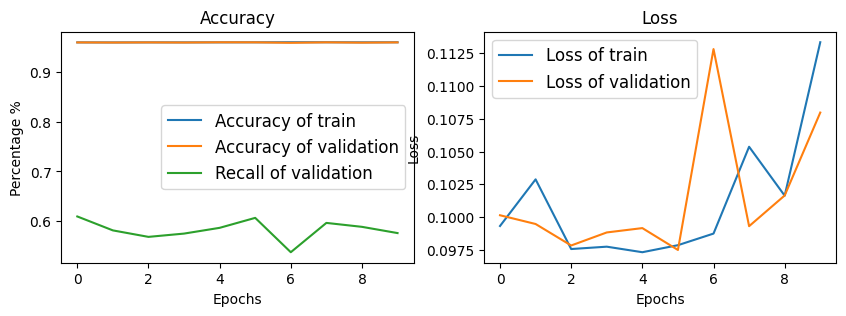

In [72]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [73]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.5769201335794703,
 'accuracy': 0.9596336743628914,
 'loss': 0.1095811128254101}

In [74]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,AKRRRLIEE,1.086940e-06,other
1,LIVEEGQRCHRF,2.642093e-01,other
2,AGTPPRVDA,9.898710e-06,other
3,EEAEQTGVSHNLMIT,7.370266e-06,other
4,GWRAPIAQI,9.977530e-10,random


45500 1009736


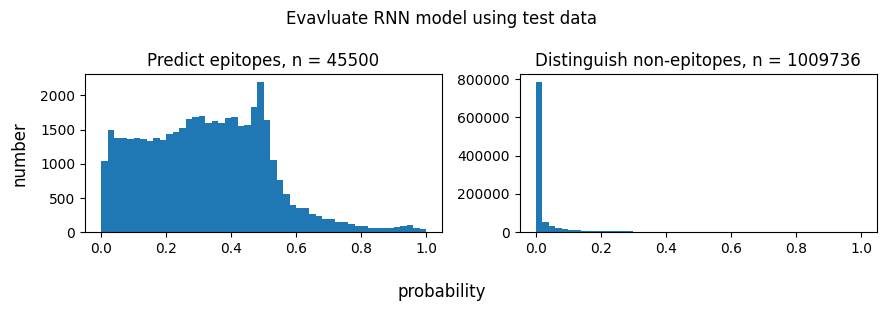

In [75]:
MyEvaluate.plot_prob(pred_test)

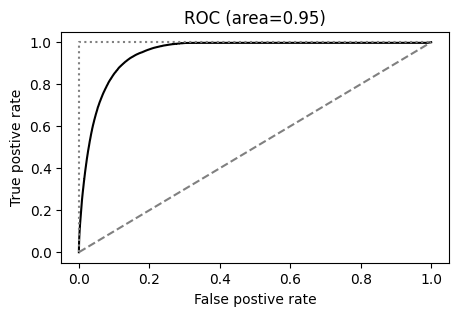

In [76]:
MyEvaluate.plot_roc(pred_test)

In [77]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_cys.pth')